In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ddm import Model, Sample
from ddm import Model
from ddm.models import DriftConstant, NoiseConstant, BoundConstant, OverlayNonDecision, ICRange
from ddm.functions import fit_adjust_model, display_model
from ddm import Fittable
from ddm.models import LossRobustBIC, LossRobustLikelihood, LossSquaredError
from ddm.functions import fit_adjust_model, fit_model
import seaborn as sns
import pickle
import scipy.io


In [41]:
df_errors = pd.read_csv('Curvature_Errors.csv')
def fit_ddm_participant(participant):
    incorrect_thresold = np.array([9/90, 15/90, 20/90, 30/90, 45/90])
    model_fits_4param = np.zeros((12, len(incorrect_thresold)), dtype = object)
    for block in range(12):
        print("Participant: ", participant)
        print("Block: ", block)
        for ic in range(len(incorrect_thresold)):
            df_rt = pd.read_csv('RTs.csv')            
            df_rt['Correct'] = df_errors['Errors'] < incorrect_thresold[ic]            
            df_rt = df_rt[df_rt['Participant_Id'] == participant]
            df_rt = df_rt[df_rt["ITs"] > .001]
            df_rt = df_rt[df_rt["ITs"] < 5]
            df_rt = df_rt.drop(['Trial', 'Unnamed: 0', 'Participant_Id', 'Rotation', 'Emphasis', 'MTs'], axis = 1)

            samp = Sample.from_pandas_dataframe(df_rt[df_rt['Block'] == block], rt_column_name="ITs", correct_column_name="Correct")
            model_fit = Model(name='Simple model (fitted)',
                          drift=DriftConstant(drift=Fittable(minval=-20, maxval=20)),
                          noise=NoiseConstant(noise=Fittable(minval = 0, maxval = 5)),                      
                          bound=BoundConstant(B=Fittable(minval = 0, maxval = 20)),
                          overlay=OverlayNonDecision(nondectime=Fittable(minval = 0, maxval = 1)),
                          dx=.001, dt=.01, T_dur=5)

            try:
                fit_adjust_model(samp, model_fit,
                             fitting_method="differential_evolution",
                             lossfunction=LossRobustLikelihood, verbose=False)
            except:
                print ("In except: ")
                print (participant, block)
            model_fits_4param[participant][block][ic] = model_fit
    return model_fits_4param

# Analyzing 4 param ddm models

In [5]:
ddm_params = np.array(pickle.load(open('ddm_fits.pickle', 'rb')))


In [104]:
ddm_params[0][0][0].get_fit_result().value()

37.19494739504438

In [105]:
drift = np.zeros((60, 12, 5))
drift_noise = np.zeros((60, 12, 5))
B = np.zeros((60, 12, 5))
Ter = np.zeros((60, 12, 5))
neg_ll = np.zeros((60, 12, 5))
for participant in range(60):
    for block in range(12):
        for ic in range(5):
            drift[participant][block][ic] = ddm_params[participant][block][ic].get_model_parameters()[0].real
            drift_noise[participant][block][ic] = ddm_params[participant][block][ic].get_model_parameters()[1].real
            B[participant][block][ic] = ddm_params[participant][block][ic].get_model_parameters()[2].real
            Ter[participant][block][ic] = ddm_params[participant][block][ic].get_model_parameters()[3].real
            neg_ll[participant][block][ic] = ddm_params[participant][block][ic].get_fit_result().value()
                        

In [106]:
ddm_fits = pd.DataFrame({'Participant_no': np.repeat(np.arange(60), 12*5),
                         'Rotation': np.tile(np.repeat(np.array(['Sudden', 'Gradual']), 12*2*5), 15),
                         'Emphasis': np.tile(np.repeat(np.array(['Speed', 'Accuracy']), 12*5), 30),
                         'Incorrect_Criterion': np.tile(np.tile(np.array(['10', '15', '20', '30', '45']), 12), 60),
                         'Block':np.tile(np.repeat(np.arange(12), 5), 60), 
                         'Drift': np.ravel(drift),
                         'Drift_Noise': np.ravel(drift_noise),
                         'Boundary': np.ravel(B), 
                         'Ter': np.ravel(Ter),
                         'neg_LL': np.ravel(neg_ll)
                        })

In [107]:
ddm_fits.to_csv('ddm_fits.csv')

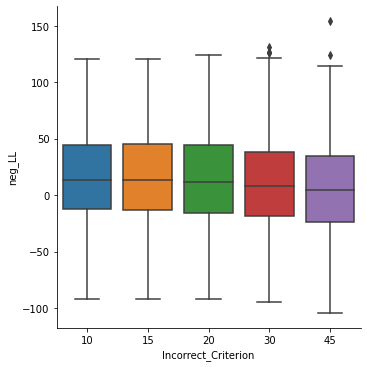

In [139]:
sns.catplot(x = "Incorrect_Criterion", y = 'neg_LL',  kind = 'box',  
           data = ddm_fits)

In [ ]:
d